In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [9]:
from detection.inference.detector import lesion_detector
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib import patches

# SET dataset

The SET dataset form Mexico of 33 patients will be used to assess the performance of the model on a test set outiside of the original distribution.<br>
- SEt images are slightly different to DE, but maintains a similar pixel distribution so we expect similar performance.

In [4]:
config_file = repo_path / 'detection/training/data/config_files/fine_tuning_CEM.yaml'
mod_num = 14
model_file = repo_path / f'detection/training/results/real-synth_improved/model_00{mod_num}999.pth' # fine-tuned 2
min_score = 0.1 # minimum score threshold to keep the prediction

detector = lesion_detector(config_file, model_file, min_score)

[03/04 12:52:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/real-synth_improved/model_0014999.pth ...


In [16]:
detector.test_df

,patient_id,image_name,region_id,bbox,lesions_per_patient
0,37,P37_L_CM_CC,1,"(91, 1084, 589, 468)",2
1,37,P37_L_CM_MLO,2,"(180, 1137, 471, 528)",2
2,47,P47_R_CM_CC,0,"(404, 223, 1130, 1156)",2
3,47,P47_R_CM_CC,1,"(199, 1253, 141, 159)",2
4,77,P77_R_CM_CC,0,"(857, 651, 325, 229)",1
...,...,...,...,...,...
135,323,P323_L_CM_CC,1,"(10, 1353, 430, 416)",6
136,323,P323_L_CM_CC,2,"(651, 1309, 150, 163)",6
137,323,P323_L_CM_CC,3,"(374, 1130, 113, 85)",6
138,323,P323_L_CM_MLO,0,"(328, 571, 400, 409)",6


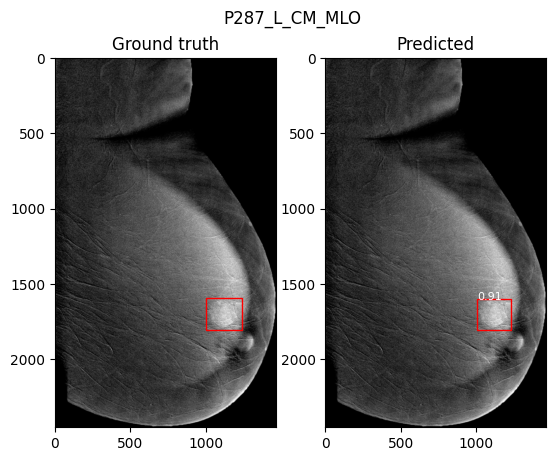

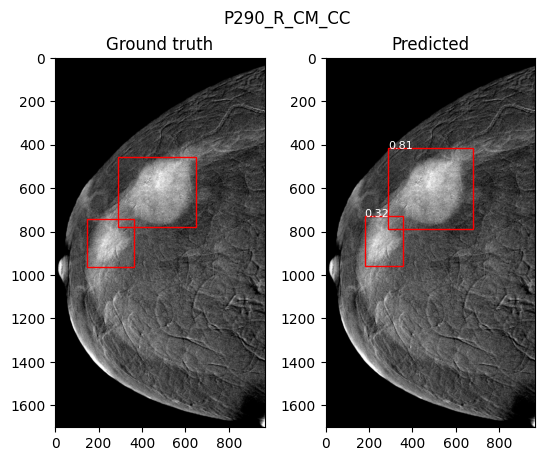

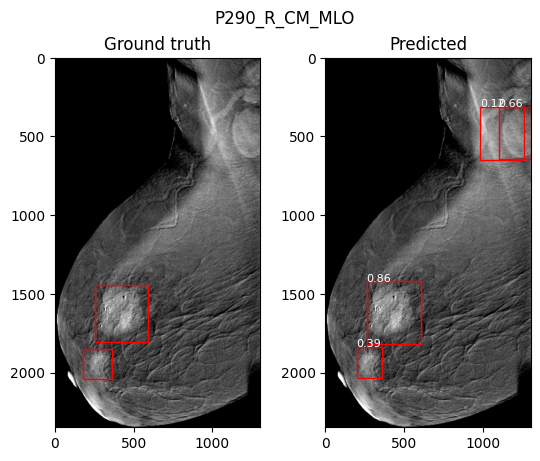

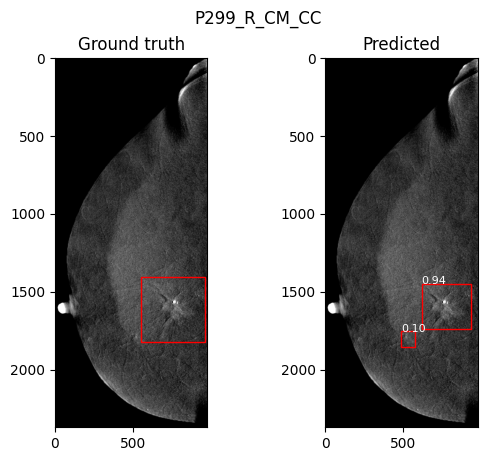

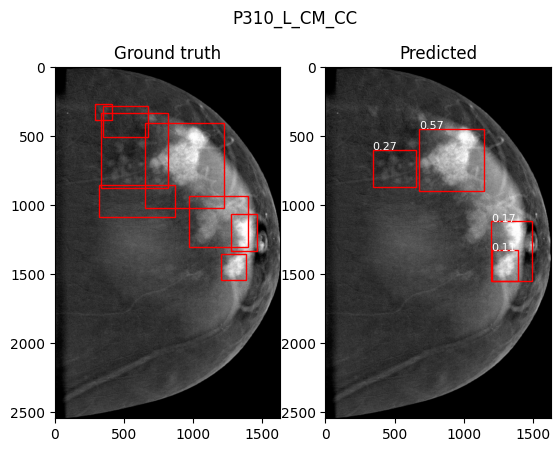

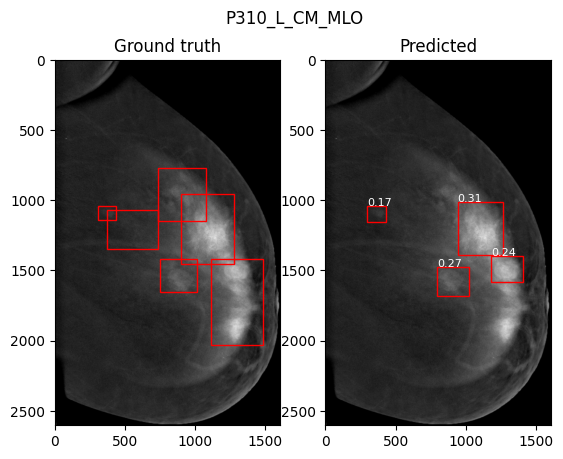

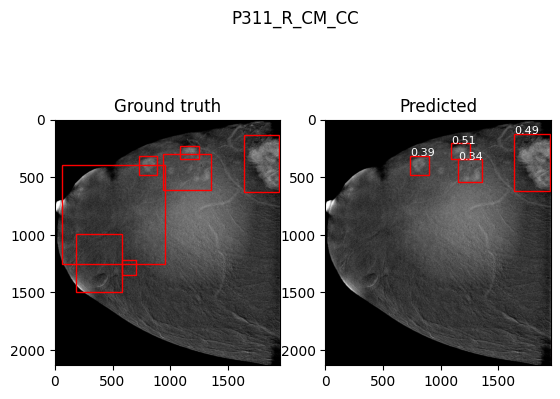

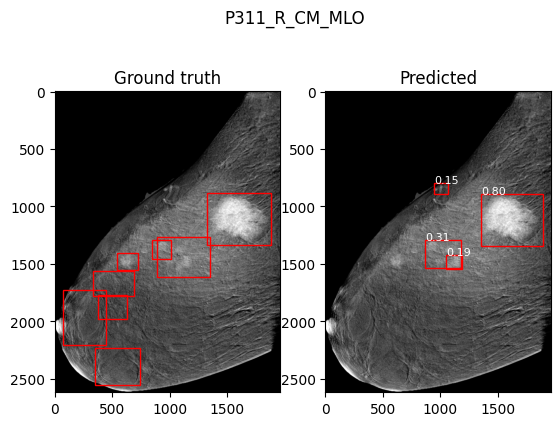

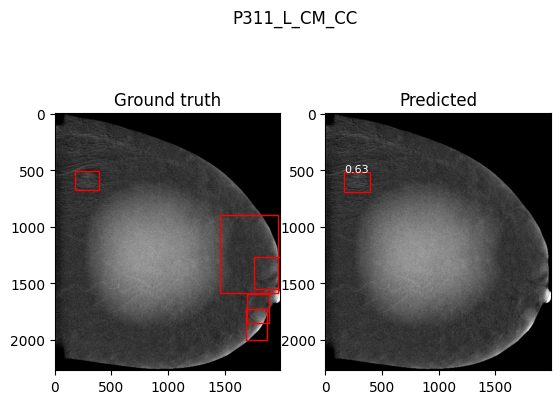

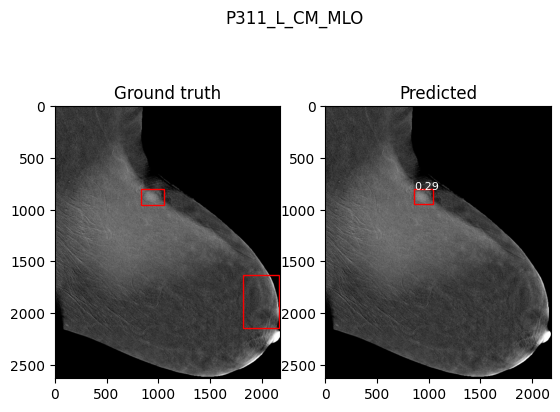

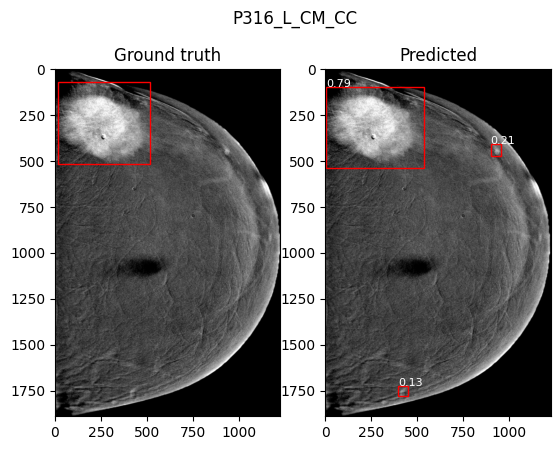

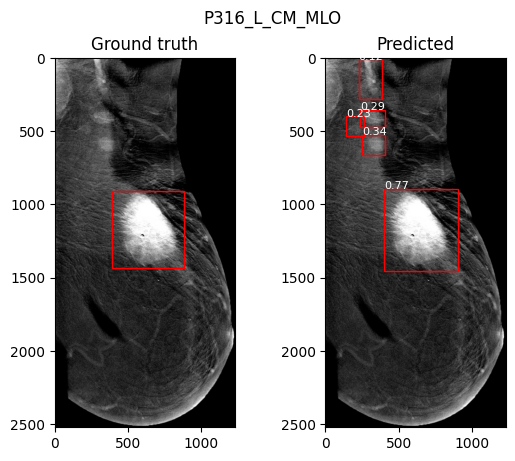

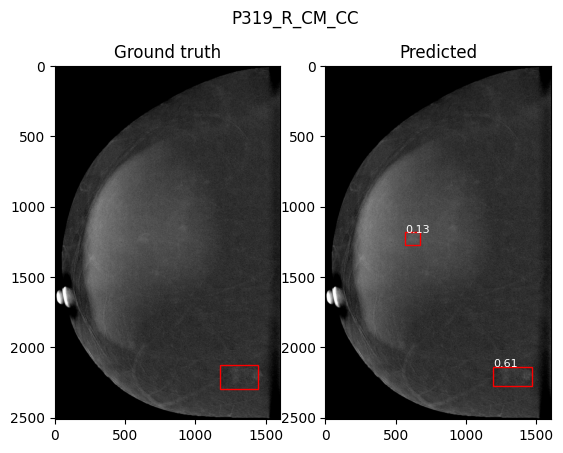

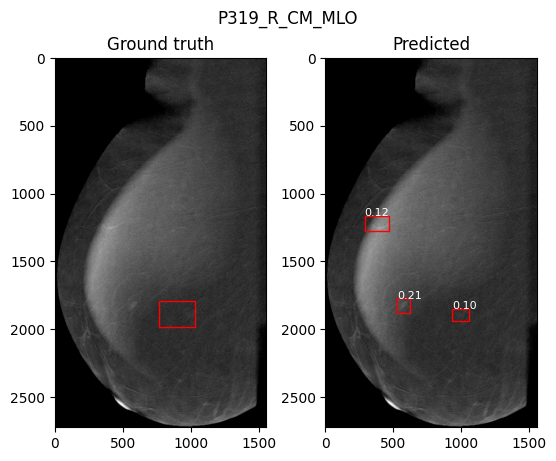

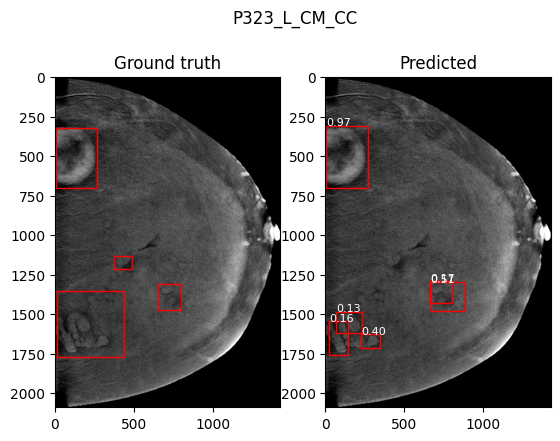

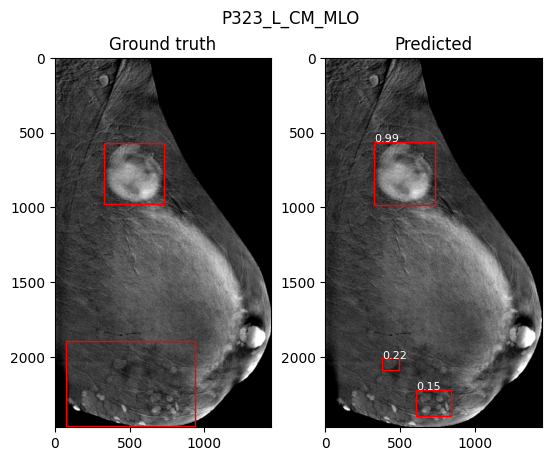

In [15]:
for im_name in detector.test_df['image_name'].unique()[40:80]:
    im_bboxes = detector.test_df[detector.test_df['image_name']==im_name] # filter bboxes for this image
    bboxes_info = [eval(bbox) for bbox in im_bboxes['bbox']] # get all regions bboxes
    gt_bboxes = [[bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] for bbox in bboxes_info]

    # read image
    im_path = detector.im_dir / f'{im_name}.jpg'
    im_array = cv.imread(str(im_path))

    # prediction
    outputs = detector.predictor(im_array)
    out = outputs["instances"].to("cpu")

    # out = post_process_pred(out)


    # show all bounding boxes on the image
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(im_array)
    ax[0].set_title('Ground truth')
    for bbox in gt_bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]), width = bbox[2]-bbox[0], height = bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
    ax[1].imshow(im_array)
    ax[1].set_title('Predicted')
    for i, bbox in enumerate(out.pred_boxes):
        rect = patches.Rectangle((bbox[0],bbox[1]), width = bbox[2]-bbox[0], height = bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)
        # add score
        ax[1].text(bbox[0],bbox[1],f'{out.scores[i]:.2f}', color='white', fontsize=8)
    # set figure tilte
    fig.suptitle(im_name)
    plt.show()